In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io
import requests

Using TensorFlow backend.


In [3]:
train_url = "https://github.com/yousenwang/DeepCOOH/blob/master/labeled_train_data_imputed_KNNImputer(add_indicator-False%20copy-True%20metric-nan_euclidean%20missing_values-nan%20n_neighbors-5%20weights-distance).csv?raw=true"
test_url = "https://raw.githubusercontent.com/yousenwang/DeepCOOH/master/labeled_test_data_imputed_KNNImputer(add_indicator-False%20copy-True%20metric-nan_euclidean%20missing_values-nan%20n_neighbors-5%20weights-distance).csv"
s1 = requests.get(train_url).content
s = requests.get(train_url).content


In [11]:
train_df = pd.read_csv(io.StringIO(s1.decode("big5")))
test_df = pd.read_csv(io.StringIO(s.decode("big5")))

In [12]:
target = 'R1COOH'

In [13]:
features = ["SB_PPM",
            "COA_PPM",
            "R1_TEMP",
            "R1_PRESSURE",
            "R1_REFLUX_RATIO",
            "R2_TEMP",
            "R2_LEVEL",
            "R2_REFLUX_RATIO",
            "z_Capacity_SUM",
            "z_Capacity_DIFF",
            "Z_R1_LEVEL_RT"]

In [19]:
train_y = train_df[target]
true_y = test_df[target]
train = train_df[features]
test = test_df[features]
print(train_y.shape, train.shape)

(676,) (676, 11)


In [65]:
train_stats =   train.describe()
train_stats = train_stats.transpose()
path = f"./train_stats.csv"
train_stats.to_csv(path, index=True, header=True)
train_stats

,count,mean,std,min,25%,50%,75%,max
SB_PPM,676.0,171.201054,45.131764,12.000000,185.000000,190.000000,190.000000,250.000000
COA_PPM,676.0,167.028615,195.401709,0.950000,80.000000,90.000000,100.000000,600.000000
R1_TEMP,676.0,262.576673,2.136377,253.866058,261.091431,263.333435,264.243988,266.666107
R1_PRESSURE,676.0,0.837329,0.075272,0.640643,0.801507,0.878799,0.881591,0.929711
R1_REFLUX_RATIO,676.0,4.297937,0.142619,3.800000,4.200000,4.300000,4.400000,4.800000
R2_TEMP,676.0,264.430920,1.190820,253.427087,263.277292,264.911320,265.176941,268.013222
R2_LEVEL,676.0,56.397985,3.087364,32.750882,55.155483,57.826050,58.151738,67.161176
R2_REFLUX_RATIO,676.0,5.528280,3.488647,2.500000,3.700000,3.900000,4.700000,13.500000
z_Capacity_SUM,676.0,512.487951,81.167738,185.000000,450.000000,564.000000,565.883071,605.000000
z_Capacity_DIFF,676.0,65.700845,73.266577,2.000000,19.993098,30.660029,78.166061,310.000000


In [32]:
def norm(x, train_stats):
  return (x - train_stats['mean'])/train_stats['std']

In [67]:
train_stats['std'].shape

(11,)

In [33]:
normed_train_X = norm(train, train_stats)

In [34]:
import tensorflow as tf
def build_model(p):
  model = Sequential([
    Dense(64, activation='relu', input_shape=[p]),
    Dense(64, activation='relu'),
    Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [35]:
p = normed_train_X.shape[1]
model = build_model(p)

In [36]:
print(p)

11


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                768       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


In [38]:
import keras
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
      print(f'{epoch}\n  ')
      !nvidia-smi

    print('.', end='')

In [39]:
!pip install -q git+https://github.com/tensorflow/docs
import keras
import tensorflow_docs as tfdocs
from tensorflow_docs.modeling import EpochDots

model = build_model(p)

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 1000
early_history = model.fit(normed_train_X, train_y, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, EpochDots(), PrintDot()])


Epoch: 0, loss:1161103.8880,  mae:1068.4686,  mse:1161103.7500,  val_loss:1229264.2941,  val_mae:1102.0710,  val_mse:1229264.2500,  
.0
  
Wed Apr 15 05:49:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 0000C575:00:00.0 Off |                  Off |
| N/A   41C    P0    39W / 150W |   7858MiB /  8129MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+---------------------------

In [40]:
from tensorflow_docs.plots import HistoryPlotter
plotter = HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

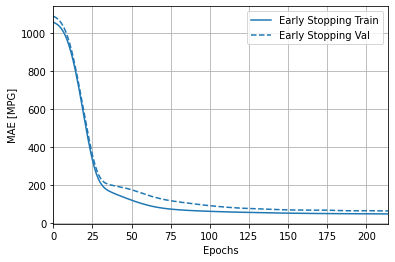

In [41]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylabel('MAE [MPG]')

In [48]:
train_stats = pd.read_csv(path, encoding = 'big5')
train_stats

,count,mean,std,min,25%,50%,75%,max
0,676.0,171.201054,45.131764,12.000000,185.000000,190.000000,190.000000,250.000000
1,676.0,167.028615,195.401709,0.950000,80.000000,90.000000,100.000000,600.000000
2,676.0,262.576673,2.136377,253.866058,261.091431,263.333435,264.243988,266.666107
3,676.0,0.837329,0.075272,0.640643,0.801507,0.878799,0.881591,0.929711
4,676.0,4.297937,0.142619,3.800000,4.200000,4.300000,4.400000,4.800000
5,676.0,264.430920,1.190820,253.427087,263.277292,264.911320,265.176941,268.013222
6,676.0,56.397985,3.087364,32.750882,55.155483,57.826050,58.151738,67.161176
7,676.0,5.528280,3.488647,2.500000,3.700000,3.900000,4.700000,13.500000
8,676.0,512.487951,81.167738,185.000000,450.000000,564.000000,565.883071,605.000000
9,676.0,65.700845,73.266577,2.000000,19.993098,30.660029,78.166061,310.000000


In [75]:
def norm(x, train_stats):
    return (x - train_stats['mean'])/train_stats['std']

In [69]:
train_stats['std']

SB_PPM              45.131764
COA_PPM            195.401709
R1_TEMP              2.136377
R1_PRESSURE          0.075272
R1_REFLUX_RATIO      0.142619
R2_TEMP              1.190820
R2_LEVEL             3.087364
R2_REFLUX_RATIO      3.488647
z_Capacity_SUM      81.167738
z_Capacity_DIFF     73.266577
Z_R1_LEVEL_RT       29.463682
Name: std, dtype: float64

In [70]:
train_stats['std'].shape

(11,)

In [76]:
normed_test_X = norm(test, train_stats)

In [77]:
normed_test_X.head()

,SB_PPM,COA_PPM,R1_TEMP,R1_PRESSURE,R1_REFLUX_RATIO,R2_TEMP,R2_LEVEL,R2_REFLUX_RATIO,z_Capacity_SUM,z_Capacity_DIFF,Z_R1_LEVEL_RT
0,0.416535,-0.343030,0.718059,0.561265,0.014466,0.964679,0.604796,-0.352079,0.462155,-0.531604,-0.495501
1,0.416535,-0.343030,0.312658,0.574405,0.014466,0.943367,0.400663,-0.352079,0.462155,-0.543336,-0.470665
2,0.416535,-0.368618,0.416594,0.570377,0.014466,1.028419,0.326105,-0.352079,0.462155,-0.534121,-0.523581
3,0.416535,-0.368618,0.302259,0.545782,0.014466,0.855113,0.477210,-0.352079,0.462155,-0.542639,-0.534095
4,0.416535,-0.368618,0.395810,0.541828,0.014466,1.074712,0.402765,-0.352079,0.462155,-0.528078,-0.502917


[]

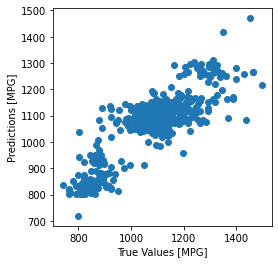

In [85]:
test_predictions = model.predict(normed_test_X).flatten()

a = plt.axes(aspect='equal')
plt.scatter(true_y, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)
plt.plot()

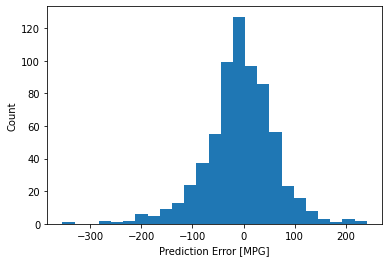

In [86]:
error = test_predictions - true_y
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [87]:
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import r2_score
def plot_tuning_graph(y_true, y_pred, final_model, p):
    fin_r2 = r2_score(y_true, y_pred)
    plt.figure()
    n_y = len(y_pred)
    y_mean = [y_true.mean() for x in range(n_y)]
    xs = [x for x in range(n_y)]
    plt.plot(xs,y_true, label = "True")
    plt.plot(xs,y_pred, label = f"{final_model.__class__.__name__} {fin_r2}", linestyle='dashed')
    plt.plot(xs,y_mean, label = "mean", linestyle='dashed')
    plot_title = f'Num of Feats: {p}'
    print(plot_title)
    print(f"test r^2 {fin_r2}")
    plt.title(plot_title)
    plt.xlabel('test samples')
    plt.ylabel('target values')
    plt.legend()
    produced_time = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    #pic_name = f'tune{final_model.__class__.__name__}_p{len(features)}_{produced_time}.jpg'
    #plt.savefig(pic_name)
    #print(f"{pic_name} was produced.")
    plt.plot()

Num of Feats: 11
test r^2 0.7414076859225768


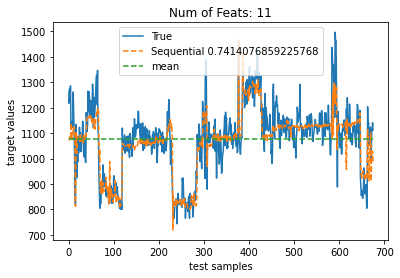

In [88]:
plot_tuning_graph(true_y, test_predictions, model, p)

Num of Feats: 11
test r^2 0.7173055969727029


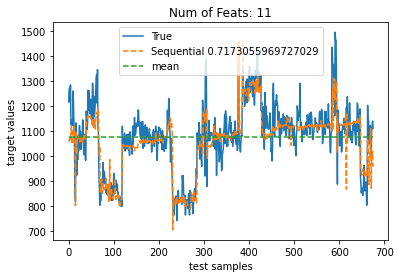

In [78]:
plot_tuning_graph(true_y, test_predictions, model, p)